In [1]:
import os

os.environ[
    "OMP_NUM_THREADS"
] = "128"  # for jupyter.nersc.gov otherwise the notebook only uses 2 cores

import matplotlib as mpl
mpl.rc('image', cmap='coolwarm')

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import healpy as hp

In [3]:
from fgbuster.observation_helpers import get_noise_realization

In [4]:
from fgbuster import (CMB, Dust, Synchrotron, AnalyticComponent,
                      basic_comp_sep, 
                      get_observation, get_instrument)

In [113]:
from fgbuster.separation_recipes import harmonic_ilc as hilc
from fgbuster.separation_recipes import _get_alms # deconvolve the beam while calculating alms

In [6]:
from plancklens.utils import camb_clfile
from lenspyx import synfast

In [7]:
import pysm3
import pysm3.units as u

# fgbuster errors

In [23]:
import sympy
from sympy.parsing.sympy_parser import parse_expr

In [39]:
analytic_expr = ('(nu / nu0)**(1 + beta_d) *'
                 '(exp(nu0 / temp * h_over_k) -1)'
                 '/ (exp(nu / temp * h_over_k) - 1)'
                 )

In [40]:
from sympy.parsing.sympy_parser import parse_expr

In [41]:
parse_expr(analytic_expr)

(nu/nu0)**(beta_d + 1)*(exp(h_over_k*nu0/temp) - 1)/(exp(h_over_k*nu/temp) - 1)

In [42]:
from scipy import constants
H_OVER_K = constants.h * 1e9 / constants.k
nu0 = 353.
temp=18
beta_d=1.6

fixed_params = {
    'nu0': nu0, 'beta_d': beta_d, 'temp': temp, 'h_over_k': H_OVER_K
}

In [43]:
parse_expr(analytic_expr).subs(fixed_params)

3.71320847732172e-7*nu**2.6/(exp(0.00266624615187012*nu) - 1)

In [45]:
Dust(353.)

SympifyError: SympifyError: None

# simulations

In [8]:
cls_path = '/global/homes/j/jianyao/non_gau_lensing/theory/cls/'

In [143]:
class simulations:
    
    def __init__(self, nside, instrument):
        
        self.nside = nside
        self.instrument = instrument
        self.fres = instrument['frequency']
        self.fwhms = instrument['fwhm']

    def get_all(self, noise = 'alms'):

        '''
        return one realization of (lensed CMB + foreground) with the beam applied + noise, 
        for each frequency defined in the instrument.
        
        noise: get noise alms or maps. 
        '''

        cl_unl = camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))
        geom_info = ('healpix', {'nside':nside}) # Geometry parametrized as above, this is the default

        lmax_unl = 2*nside
        cmb_temp = synfast(cl_unl, lmax=lmax_unl, verbose=1, geometry=geom_info, alm = False)
        self.cmb_len = np.row_stack((cmb_temp['T'], cmb_temp['QU'])) # (3, 12*nside**2)

        Nf = self.fres.size
        cmb_maps = np.repeat(self.cmb_len[np.newaxis, :, :], Nf, axis = 0)
        observations = get_observation(instrument, 'd0', nside=nside, noise=False)
        noise_maps = get_noise_realization(nside, instrument, unit='uK_CMB')
        noise_alms = []
        
        map_all = cmb_maps + observations
        for i in range(Nf):
            # map_all[i] = pysm3.apply_smoothing_and_coord_transform(map_all[i], fwhm=self.fwhms[i]*u.arcmin) + self.noise_maps[i]
            map_all[i] = hp.smoothing(map_all[i], fwhm = self.fwhms[i]/180/60*np.pi) + noise_maps[i]
            
            if noise == 'alms':
                noise_alms.append(hp.map2alm(noise_maps[i]))
                
        if noise == 'maps':
            self.noise_maps = noise_maps
        elif noise == 'alms':
            self.noise_alms = noise_alms
                
        self.map_all = map_all
    
    def apply_hilc(self, components, lbins):
        
        '''
        apply fgbuster.hilc method to get clean CMB map
        '''
        
        results = hilc(components, self.instrument, self.map_all, lbins) 
        ### data are deconvolved when transforming to alms, 
        ### then using harmonic_ilc_alm to do the component separation
        weighted_alms = []
        
        noise_alms_ilc = np.copy(self.noise_alms)
        # all_alms = _get_alms(sims.map_all, instrument.fwhm, lmax = 450)
        
        for i in range(self.fres.size):
            # bl = hp.gauss_beam(np.radians(self.fwhms[i]/60.0), lmax = lbins[-1], pol=True)
            # all_alms = hp.map2alm(self.map_all[i], lmax = lbins[-1])
            for j in range(3): # T, E, B
                # hp.almxfl(all_alms[j], results.W[j, :, 0, i]/bl[:, j], inplace = True)  ### simulated total maps are deconvolved 
                hp.almxfl(noise_alms_ilc[i][j], results.W[j, :, 0, i], inplace = True)  ### simulated ilc noise maps are not deconvolved during the component separation
            # weighted_alms.append(all_alms)
            
        # cmb_alms = np.sum(weighted_alms, axis = 0)
        noise_ilc_alms = np.sum(noise_alms_ilc, axis = 0) 
        
        return results, noise_ilc_alms

In [132]:
nside = 256
instrument = get_instrument('SO_LAT')

sims = simulations(nside, instrument)
sims.get_all(noise = 'alms')

  cl matrix        :  [0:00:00.003944] (1.9%)  
  phases generation:  [0:00:00.011059] (5.4%)  
  alms from phases :  [0:00:00.012727] (6.2%)  
  alm2lenmap       :  [0:00:00.174919] (85.3%)  
  Total            :  [0:00:00.205105] d:h:m:s:mus


(6, 3, 786432)

# HILC

In [118]:
components = [CMB()]
lbins = np.arange(10)*50

In [84]:
results, cls, cmb = sims.apply_hilc(components, lbins)

In [133]:
results_de, cls_de, cmb_de, noise_ilc = sims.apply_hilc(components, lbins)

In [142]:
noise_ilc.shape

(3, 295296)

Text(0.5, 1.0, 'full-sky, Cl')

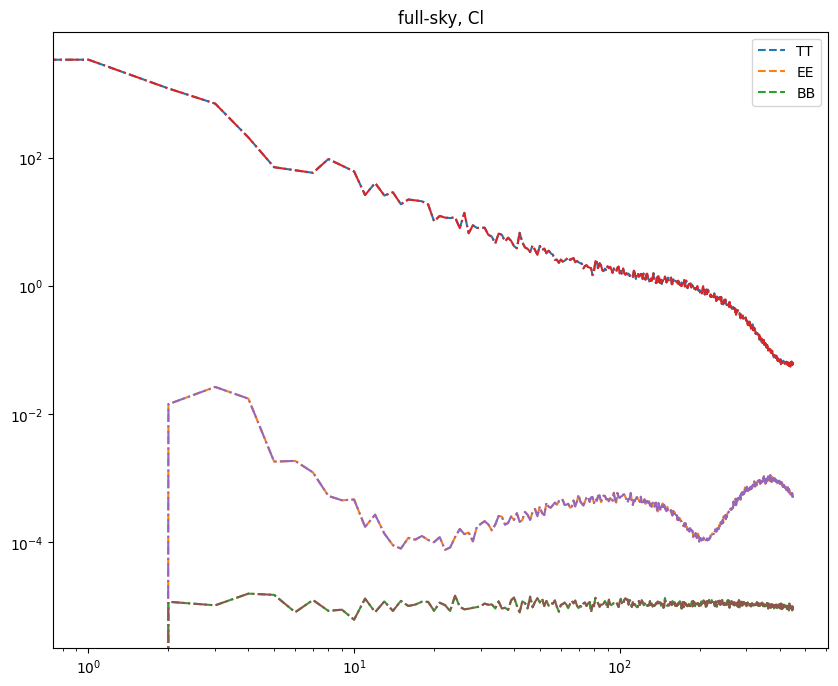

In [139]:
plt.figure(figsize = (10, 8))
s = 0; e = -1
coeff = ells*(ells+1)/2/np.pi #*coeff
plt.plot(results_de['cl_out'][0][0][s:e], '--', label = 'TT')
plt.loglog(results_de['cl_out'][0][1][s:e], '--', label = 'EE')
plt.loglog(results_de['cl_out'][0][2][s:e], '--', label = 'BB')
plt.loglog(cls_de[0][s:e], '-.')
plt.loglog(cls_de[1][s:e], '-.')
plt.loglog(cls_de[2][s:e], '-.')
plt.legend()
plt.title('full-sky, Cl')

Text(0.5, 1.0, 'full-sky, Cl')

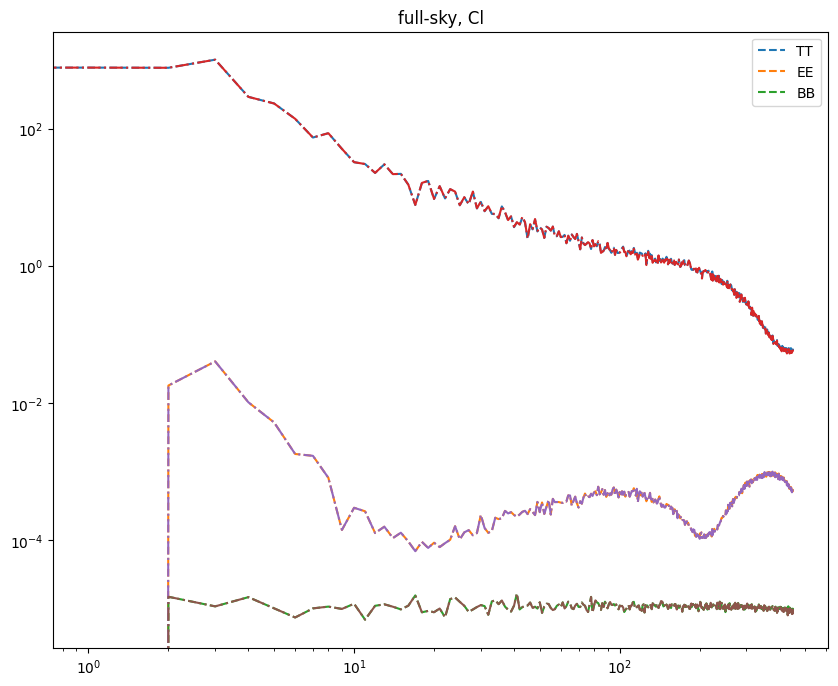

In [115]:
plt.figure(figsize = (10, 8))
s = 0; e = -1
coeff = ells*(ells+1)/2/np.pi #*coeff
plt.plot(results['cl_out'][0][0][s:e], '--', label = 'TT')
plt.loglog(results['cl_out'][0][1][s:e], '--', label = 'EE')
plt.loglog(results['cl_out'][0][2][s:e], '--', label = 'BB')
plt.loglog(cls[0][s:e], '-.')
plt.loglog(cls[1][s:e], '-.')
plt.loglog(cls[2][s:e], '-.')
plt.legend()
plt.title('full-sky, Cl')

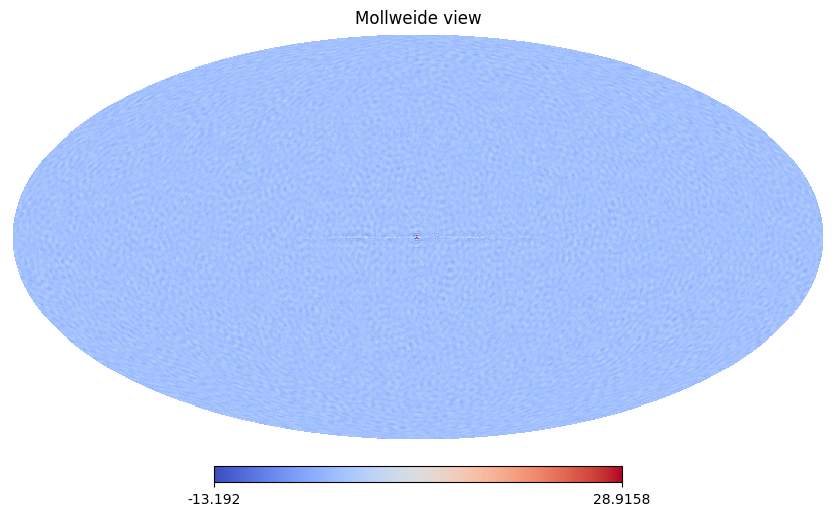

In [96]:
hp.mollview(results.s[0, 0] - cmb[0])

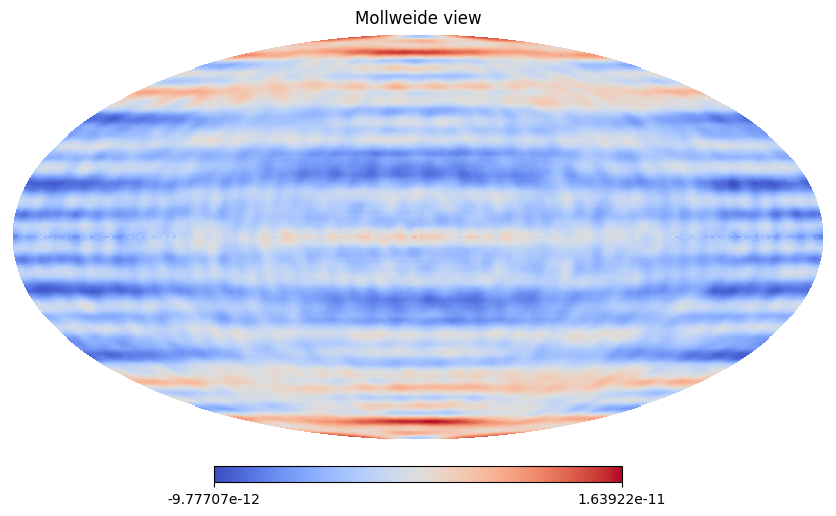

In [140]:
hp.mollview(results_de.s[0, 0] - cmb_de[0])